## Analisis de errores: Calibracion

**Autor**: Jesús del Hoyo

**Fecha**:   08/11/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

En esta ocasión voy a tratar de analizar cómo se relacionan los errores en los residuos de intensidad con los parámetros ajustados durante los experimentos de calibración. En primera aproximación, no voy a considerar cómo afectan los errores de un paso al siguiente.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp
from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat
from multiprocessing.dummy import Pool

from polarimeter.utils import plot_2d, generate_even_distribution

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting
from matplotlib.colors import LogNorm
from matplotlib import ticker, colors


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import phyton_optics.utils_multiprocessing as multiproc
import numpy as np
from itertools import product as prod
import os

C:\Users\Jesus\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Funcion para hacer plots
def plot_contours(Z, contour_param=[1e-3,1,3], extension=[0, 1, 0, 1], labels=["","",""], fig_size=0):
    # Create levels
    lev_min = np.floor(np.log10(contour_param[0]))
    lev_max = np.ceil(np.log10(contour_param[1]))
    Nlevels = (lev_max-lev_min) * np.ceil(contour_param[2]) + 1
    levs = np.logspace(lev_min, lev_max, Nlevels)
    # Plot the result
    if fig_size is not 0:
        if len(fig_size) is 1:
            plt.figure(figsize=(fig_size,fig_size))
        else:            
            plt.figure(figsize=fig_size)
    IDimage = plt.contourf(
            Z,
            levels = levs,
            norm=colors.LogNorm(),
            origin='lower',
            extent=extension
    )
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[2])
    plt.colorbar()
    IDimage.set_cmap("magma")

## Ley de Malus (multiprocessing)

Es repetir lo anterior con multiprocessing a ver si mejora.

**Polarizador conocido**

In [3]:
import os
direc = 'D:\codigo\polarimeter\notebooks\Analisis de errores'
#os.chdir(direc)

%run Malus_Law.py
#print(results)

C:\Users\Jesus\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


La ejecucion de prueba tardo: 37.6499998569 s
[0.17962039255097506, 0.01111553096406213, 0.07587054702734687, 0.020797191150493787, 1]
Multithreading finalizado
Elapsed time is: 50.3009998798 s.


[1e-10, 0.019930580351637837, 0.009803413296522267]
[5.729577951308233e-09, 0.28244224398825746, 0.08645446751366184]
[1e-10, 0.0028616576198206753, 0.0008041893774149564]
[1e-10, 0.03469033604770317, 0.011433933023247682]


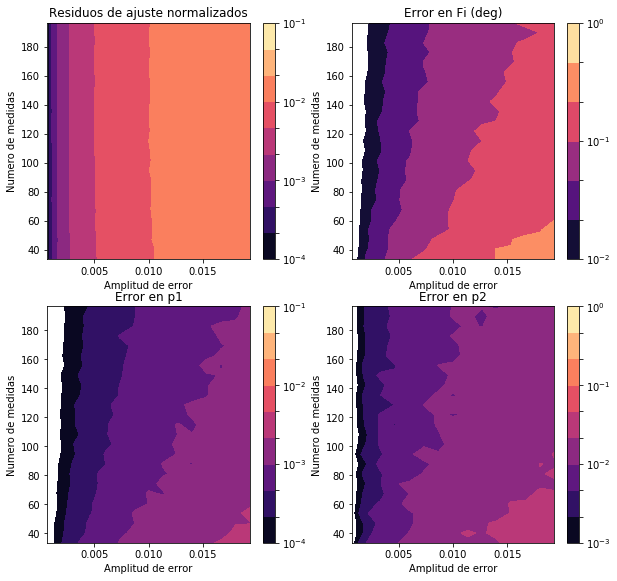

In [9]:
# Parameters
Nfigs = 4
LowThres = [1e-4, 1e-2, 1e-4, 1e-3]
HighThres = [0.1, 1, .1, 1]
Nlevels = 3*np.ones(Nfigs)

# Juntar errores de parametros similares
Nrows = np.ceil(Nfigs)
merged = range(Nfigs)
merged[0] = np.matrix(results[0]).T
merged[1] = np.matrix(results[3]).T/(degrees)
merged[2] = np.matrix(results[1]).T
merged[3] = np.matrix(results[2]).T
titles = ["Residuos de ajuste normalizados", "Error en Fi (deg)","Error en p1", "Error en p2"]

# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot
plt.figure(figsize=(10,5*Nrows))
for ind in range(Nfigs):
    print([merged[ind].min(), merged[ind].max(), np.mean(merged[ind])])
    contour_param = [LowThres[ind], HighThres[ind], Nlevels[ind]]
    labels = ["Amplitud de error","Numero de medidas",titles[ind]]
    plt.subplot(Nrows,2,ind+1)
    plot_contours(merged[ind], contour_param, extension, labels)

Text(0.5,1,'Error en el angulo')

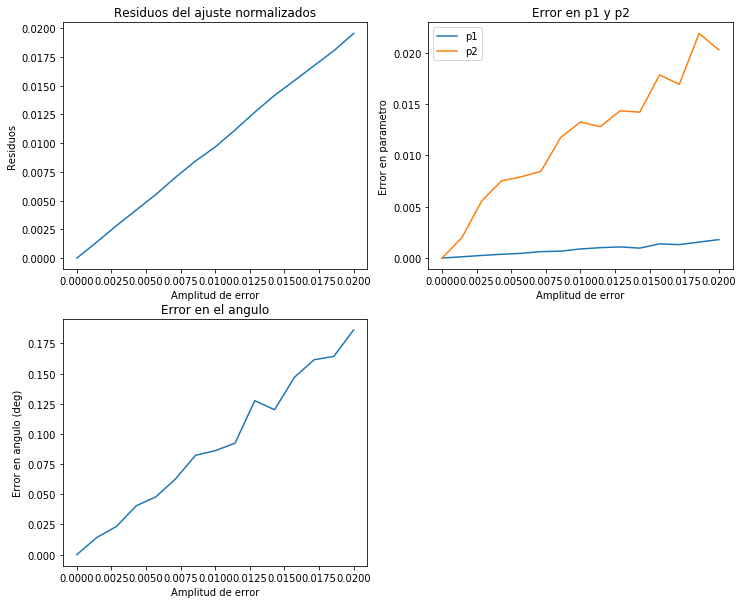

In [10]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(error_array,results[0][:,8])
plt.ylabel("Residuos")
plt.xlabel("Amplitud de error")
plt.title("Residuos del ajuste normalizados")

plt.subplot(2,2,2)
plt.plot(error_array,results[1][:,8])
plt.plot(error_array,results[2][:,8])
plt.ylabel("Error en parametro")
plt.xlabel("Amplitud de error")
plt.title("Error en p1 y p2")
plt.legend(['p1','p2'])

plt.subplot(2,2,3)
plt.plot(error_array,results[3][:,8]/degrees)
plt.ylabel("Error en angulo (deg)")
plt.xlabel("Amplitud de error")
plt.title("Error en el angulo")

Tarda mucho menos, así que nos vamos a quedar con multiprocessing.

## Triple ley de Malus

Ahora vamos con el siguiente caso, cuando calibramos los tres polarizadores.

In [3]:
%run Triple_Malus_Law.py

Parametros iniciales: p1 = 0.855125698221; p2 = 0.0855985657233;  p3 = 0.979146364627; p4 = 0.121495040921; p5 = 0.951676431266; p6 = 0.0828143014063;
Angulos iniciales: fi1 = 98.0250033907 deg; fi2 = 162.856173041 deg;  fi3 = 92.6464246557 deg;
Parametros del ajuste: p1 = 0.848572557204; p2 = -7.31034227579e-05;  p3 = 0.992269385514; p4 = 0.156036825374; p5 = 0.952169447794; p6 = -3.1724453583e-05;
Angulos del ajuste: fi1 = 96.6279604035 deg; fi2 = 162.93989268 deg;  fi3 = 93.4431393178 deg;
Errores en param: p1 = 0.00655314101737; p2 = 0.0856716691461;  p3 = -0.0131230208876; p4 = -0.0345417844529; p5 = -0.000493016527791; p6 = 0.0828460258599;
Errores en angulos: fi1 = 1.39704298712 deg; fi2 = 0.0837196389298 deg;  fi3 = 0.79671466209 deg;
 
Parametros iniciales: p1 = 0.997083483875; p2 = 0.0498471999352;  p3 = 0.930100932097; p4 = 0.178017082284; p5 = 0.956439627171; p6 = 0.00439793498158;
Angulos iniciales: fi1 = 175.015942247 deg; fi2 = 152.771004243 deg;  fi3 = 6.61537517344 deg

[1e-10, 0.020003790719696154, 0.00982006199183474]
[1e-10, 0.002643869870491872, 0.0006947604524254219]
[1e-10, 0.02512771204443584, 0.010102169068910137]
[5.729577951308232e-09, 0.408834110268743, 0.11829325395251497]


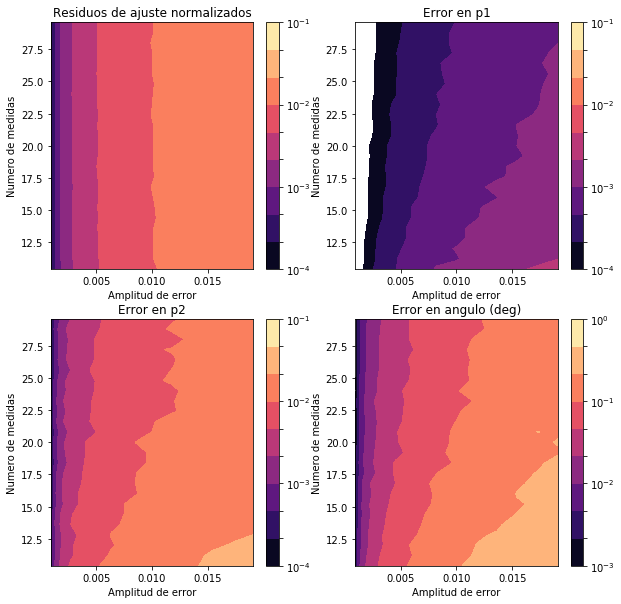

In [7]:
# Parameters
LowThres = [1e-4, 1e-4, 1e-4, 1e-3]
HighThres = [0.1, 0.1, 0.1, 1]
Nlevels = [3, 3, 3, 3]

load_data = True
if load_data:
    filename = 'Triple_Malus_Law_2018-11-30.npz'
    data = np.load(filename)
    results = data['results']

# Juntar errores de parametros similares
merged = range(4)
merged[0] = np.matrix(results[0]).T
merged[1] = np.matrix(results[1]+results[3]+results[5]).T/3
merged[2] = np.matrix(results[2]+results[4]+results[6]).T/3
merged[3] = np.matrix(results[7]+results[8]+results[9]).T/(3*degrees)
titles = ["Residuos de ajuste normalizados", "Error en p1", "Error en p2", "Error en angulo (deg)"]

# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot
plt.figure(figsize=(10,10))
for ind in range(4): 
    print([merged[ind].min(), merged[ind].max(), np.mean(merged[ind])])    
    contour_param = [LowThres[ind], HighThres[ind], Nlevels[ind]]
    labels = ["Amplitud de error","Numero de medidas",titles[ind]]
    plt.subplot(2,2,ind+1)
    plot_contours(merged[ind], contour_param, extension, labels)

## Calibracion del primer retardador

En este caso calibramos el primer retardador, y de bonus tenemos el delay del polarizador 1. Suponemos que el resto de parámetros de los polarizadores (p1, p2 y angulo) son perfectamente conocidos.

In [11]:
%run First_Retarder.py

La ejecucion de prueba tardo: 77.5990002155 s
[0.09891402072227891, 0.009217414474432445, 0.009116100599503343, 0.03233021622727921, 0.013376552395863887, 0.4296979336152427, 1e-10]
Multithreading finalizado
Elapsed time is: 8496.49700022 s.


<Figure size 432x288 with 0 Axes>

[1e-10, 0.020000046753682086, 0.009904234171176664]
[1e-10, 0.0025742822683530436, 0.0007372210342849009]
[5.729577951308233e-09, 0.4961423290507877, 0.13639013726696017]
[5.729577951308233e-09, 31.486496914595584, 5.620841362568766]
[5.729577951308233e-09, 0.18937698481161155, 0.056958332288164305]


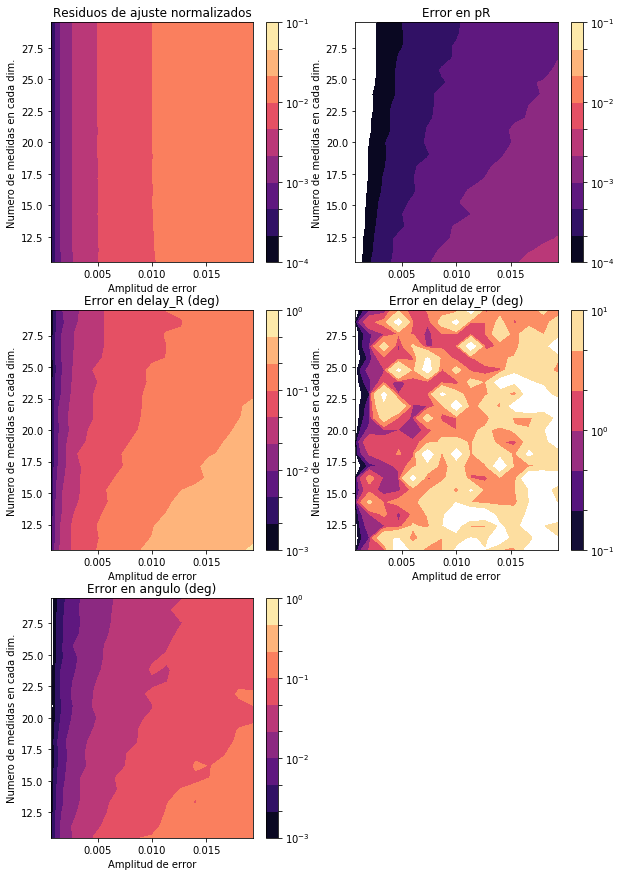

In [12]:
# Parameters
LowThres = [1e-4, 1e-4, 1e-3, 1e-1, 1e-3]
HighThres = [0.1, 0.1, 1, 10, 1]
Nlevels = [3, 3, 3, 3, 3]
Nfigs = 5
load_data = False
if load_data:
    filename = 'First_Retarder_2018-11-26.npz'
    data = np.load(filename)
    results = data['results']

# Juntar errores de parametros similares
merged = range(Nfigs)
merged[0] = np.matrix(results[0]).T
merged[1] = np.matrix(results[1]+results[2]).T/2
merged[2] = np.matrix(results[3]).T/degrees
merged[3] = np.matrix(results[5]).T/degrees
merged[4] = np.matrix(results[4]).T/degrees
titles = ["Residuos de ajuste normalizados", "Error en pR", "Error en delay_R (deg)", 
          "Error en delay_P (deg)", "Error en angulo (deg)"]

# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot
Nrows = np.ceil(Nfigs/2.0)
plt.figure(figsize=(10,5*Nrows))
for ind in range(Nfigs):    
    print([merged[ind].min(), merged[ind].max(), np.mean(merged[ind])])
    contour_param = [LowThres[ind], HighThres[ind], Nlevels[ind]]
    labels = ["Amplitud de error","Numero de medidas en cada dim.",titles[ind]]
    plt.subplot(Nrows,2,ind+1)
    plot_contours(merged[ind], contour_param, extension, labels)

## Calibracion del segundo retardador

En este caso calibramos el segundo retardador. Suponemos que el resto de parámetros de los polarizadores y el retardador 1(p1, p2, pR, delay y angulo) son perfectamente conocidos.

In [8]:
%run Second_Retarder.py

KeyboardInterrupt: 

[1e-10, 0.02003249337284177, 0.00991947231155303]
[1e-10, 0.0022870385968998285, 0.000677026769810956]
[5.729577951308233e-09, 0.6704825469309016, 0.19115614210044185]
[5.729577951308233e-09, 0.18849222961078554, 0.04977529932169608]


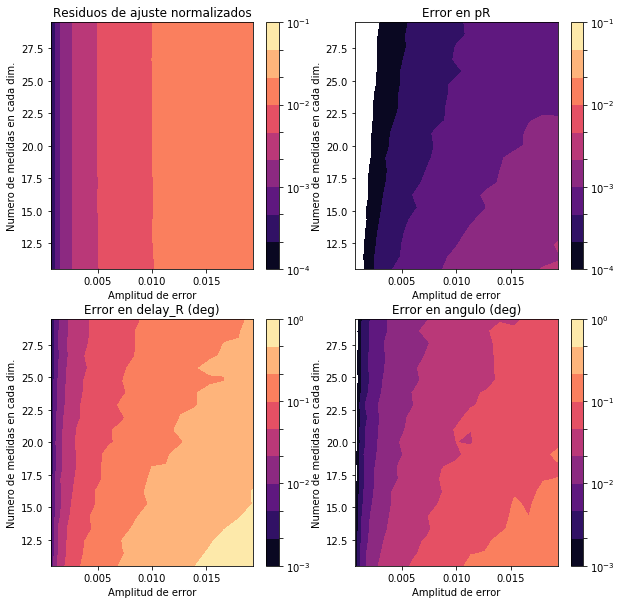

In [6]:
# Parameters
LowThres = [1e-4, 1e-4, 1e-3, 1e-3]
HighThres = [0.1, 0.1, 1, 1]
Nlevels = [3, 3, 3, 3]
Nfigs = 4
load_data = False
if load_data:
    filename = 'Second_Retarder_2018-11-28.npz'
    data = np.load(filename)
    results = data['results']

# Juntar errores de parametros similares
merged = range(Nfigs)
merged[0] = np.matrix(results[0]).T
merged[1] = np.matrix(results[1]+results[2]).T/2
merged[2] = np.matrix(results[3]).T/degrees
merged[3] = np.matrix(results[4]).T/degrees
titles = ["Residuos de ajuste normalizados", "Error en pR", "Error en delay_R (deg)", 
          "Error en angulo (deg)"]

# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot
Nrows = np.ceil(Nfigs/2.0)
plt.figure(figsize=(10,5*Nrows))
for ind in range(Nfigs):    
    print([merged[ind].min(), merged[ind].max(), np.mean(merged[ind])])
    contour_param = [LowThres[ind], HighThres[ind], Nlevels[ind]]
    labels = ["Amplitud de error","Numero de medidas en cada dim.",titles[ind]]
    plt.subplot(Nrows,2,ind+1)
    plot_contours(merged[ind], contour_param, extension, labels)

## Calibracion del analizador de estados

Por último, analizo los errores producidos en el analizador de estados. De nuevo, parto de tener un polarizador y un retardador conocidos. El vector de Stokes a medir lo voy a caracterizar como general, es decir, funcion del azimut, la elipticidad y el grado de polarización.

In [4]:
%run Analizer.py

La ejecucion de prueba tardo: 184.248000145 s
[0.09856175112048593, 0.3851218640980774, 0.0818643665516834, 0.01848500361473276, 1e-10]
Preparandose para el multiprocessing
Guardando datos
Iniciando el procesado con un solo nucleo
Multithreading finalizado
Elapsed time is: 103806.579 s.


[1e-10, 0.02001609007430426, 0.009939871043065119]
[5.729577951308233e-09, 17.52927068975233, 3.703477347242511]
[5.729577951308233e-09, 6.427553907667494, 0.9125039708021332]
[1e-10, 0.005652867221571916, 0.001535778531219717]


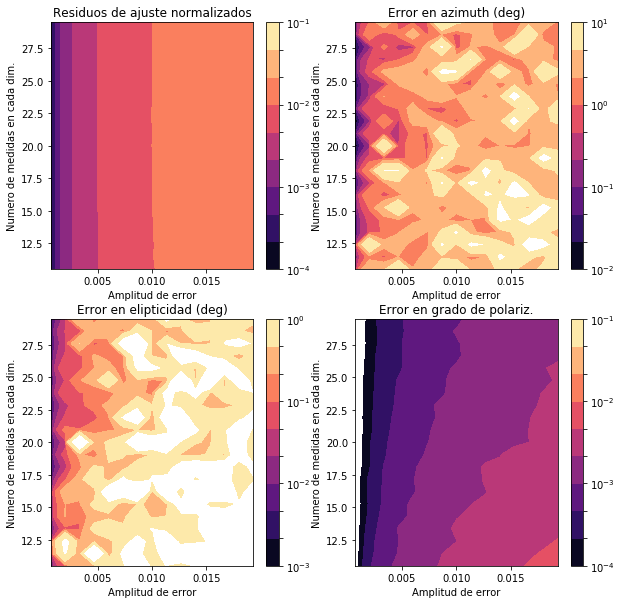

In [5]:
# Parameters
LowThres = [1e-4, 1e-2, 1e-3, 1e-4]
HighThres = [0.1, 10, 1, 0.1]
Nlevels = [3, 3, 3, 3]
Nfigs = 4
load_data = False
if load_data:
    filename = 'Analizer_2018-12-03.npz'
    data = np.load(filename)
    results = data['results']

# Juntar errores de parametros similares
merged = range(Nfigs)
merged[0] = np.matrix(results[0]).T
merged[1] = np.matrix(results[1]).T/degrees
merged[2] = np.matrix(results[2]).T/degrees
merged[3] = np.matrix(results[3]).T
titles = ["Residuos de ajuste normalizados", "Error en azimuth (deg)", "Error en elipticidad (deg)", 
          "Error en grado de polariz."]

# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot
Nrows = np.ceil(Nfigs/2.0)
plt.figure(figsize=(10,5*Nrows))
for ind in range(Nfigs):    
    print([merged[ind].min(), merged[ind].max(), np.mean(merged[ind])])
    contour_param = [LowThres[ind], HighThres[ind], Nlevels[ind]]
    labels = ["Amplitud de error","Numero de medidas en cada dim.",titles[ind]]
    plt.subplot(Nrows,2,ind+1)
    plot_contours(merged[ind], contour_param, extension, labels)

In [16]:
S = np.matrix(np.array([[1], [0], [0], [0]]))
S[1] = 5
print(S)

[[1]
 [5]
 [0]
 [0]]


In [34]:
from scipy import sin
print(cos(0.22583473*2))

0.8997196903131329


## Auxiliar

En esta sección guardo la ejecución del caso de la Ley de Malus con un solo procesador, y on multithreading. Puesto que es más eficiente usar multiprocessing (aunque no se si por usar una clase aparte o no), me quedé con el multiprocessing.

**Ley de Malus (multithreading)**

Vamos a empezar por la ley de Malus. Hay dos casos aquí, uno en que consideramos los parámetros de un polarizador conocido, y otro en que hacemos el experimento 3 veces.

In [ ]:
# Funcion que convierte varios arrays en un solo iterable que contiene todos los elementos
# de manera analoga a multiples bucles
def unir_en_iterable(arrays):
    # Calcular el numero de elementos y el tamaño de cada array
    l = len(arrays)
    N_elem = 1
    tamanos = np.zeros(l)
    for ind in range(l):
        arrays[ind] = np.array(arrays[ind]) # Por si no era un array, usar siempre el mismo metodo
        N_elem = N_elem * arrays[ind].size     
    # Inicializar el array de resultado
    result = []
    # Make the loop depending on the number of elements
    if l == 2:
        # Dos bucles
        for ind0, elem0 in enumerate(arrays[0]):
            for ind1, elem1 in enumerate(arrays[1]):
                new = [elem0, elem1]
                result = result + [new]
    elif l == 3:
        # Tres bucles        
        for ind0, elem0 in enumerate(arrays[0]):
            for ind1, elem1 in enumerate(arrays[1]):
                for ind2, elem2 in enumerate(arrays[2]):
                    new = [elem0, elem1, elem2]
                    result = result + [new]
    elif l == 4:
        # Cuatro bucles      
        for ind0, elem0 in enumerate(arrays[0]):
            for ind1, elem1 in enumerate(arrays[1]):
                for ind2, elem2 in enumerate(arrays[2]):
                    for ind3, elem3 in enumerate(arrays[3]):
                        new = [elem0, elem1, elem2, elem3]
                        result = result + [new]
    else:
        raise ValueError('No se ha implementado l = {}'.format(l))
    return result

# Funcion inversa a la anterior
def desdoblar_desde_iterable(iterable, shape):
    # Averiguar el numero de variables diferentes que habra
    N_var = len(iterable[0])
    # Make iterable array
    iterable = np.array(iterable)
    # Cambiar la forma de las variables 
    variables = range(N_var)
    for indV in range(N_var):
        variables[indV] = np.reshape(iterable[:,indV], shape)
    # Fin
    return variables

In [4]:
# Prueba de que funciona
a = unir_en_iterable([range(2), range(3), range(2)])
print(a)
b = desdoblar_desde_iterable(a, [3,4])
print(b)

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [0, 2, 0], [0, 2, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1], [1, 2, 0], [1, 2, 1]]
[array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [1, 1, 1, 1]]), array([[0, 0, 1, 1],
       [2, 2, 0, 0],
       [1, 1, 2, 2]]), array([[0, 1, 0, 1],
       [0, 1, 0, 1],
       [0, 1, 0, 1]])]


In [5]:
# Funcion que aborda cada caso particular. Esta es la funcion que llamara el metodo de 
# multithreading, y solo puede tener un argumento
def funcion_single_thread(params):
    # Operaciones de inicio
    #print(params)
    # Desacoplar los parametros
    (error, Nangulos) = params
    Nangulos = int(round(Nangulos))
    # Crear array con los resultados para despues promediar
    ajuste_p1 = np.zeros(Naverages)
    ajuste_p2 = np.zeros(Naverages)
    ajuste_fi = np.zeros(Naverages)
    ajuste_error = np.zeros(Naverages)
    # Bucle para promediar
    for indAv in range(Naverages):
        # Matrices de Mueller
        (p1, p3) = min_p1 + (max_p1-min_p1)*np.random.rand(2)
        (p2, p4) = min_p2 + (max_p2-min_p2)*np.random.rand(2)
        fi = min_angulo + (max_angulo-min_angulo)*np.random.rand(1)
        Mp1 = ps.polarizer_linear(p1, p2, theta=0)
        Mp2 = ps.polarizer_linear(p3, p4, theta=fi)
        M_malus = [Mp2, Mp1]
        theta = np.linspace(min_angulo, max_angulo, Nangulos)
        # Crear el experimento "real"
        Intensity = opsys.Intensity_Rotating_Elements(M_malus, [theta, 0], Illum)
        # Añadir errores en los valores de intensidad
        Intensity_error = Intensity + error * np.random.randn(Nangulos)
        # Ajustar el experimento con errores por minimos cuadrados
        par0 = [p3, p4, fi]
        par1, success = optimize.leastsq(
            error_modelo, par0, args=(theta, Mp1, Intensity_error))
        # Calcular el error en la distribucion
        residuos = error_modelo(par1, theta, Mp1, Intensity_error)
        # Dar resultados
        ajuste_error[indAv] = np.linalg.norm(residuos)/Intensity_error.max()
        ajuste_p1[indAv] = par1[0]-p1
        ajuste_p2[indAv] = par1[1]-p2
        ajuste_fi[indAv] = par1[2]-fi
    # Hacer media
    resultado = [np.mean(ajuste_error),
                np.linalg.norm(ajuste_p1),
                np.linalg.norm(ajuste_p2),
                np.linalg.norm(ajuste_fi)]
    return resultado
        
# Funciones de modelo
def modelo_teor(par, th1, Mp1): 
    # Create Jones matrices
    M_incognita = ps.polarizer_linear(p1=par[0], p2=par[1])
    M = [M_incognita, Mp1]
    th = [th1-par[2], 0]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Illum)
    return Iteor
def error_modelo(par, th1, Mp1, Ireal): 
    Iteor = modelo_teor(par, th1, Mp1)
    diferencia = Iteor - Ireal
    return diferencia

In [10]:
tic = time.time()
# Espacio de medida
Nerrores = 5
Nmedidas = 5
Naverages = 100
N_threads = 8
(min_error, max_error) = (0, 0.02)
(min_medidas, max_medidas) = (30, 200)
(min_angulo, max_angulo) = (0, 180*degrees)
(min_p1, max_p1) = (0.8, 1)
(min_p2, max_p2) = (0.0, 0.2)
factor = 0.246
Illum = ps.circular_light()
# arrays
error_array = np.linspace(min_error, max_error, Nerrores)
medidas_array = np.linspace(min_medidas, max_medidas, Nmedidas)
#result = np.zeros([Nmedidas,Nerrores])
# Fusionar ambos arrays en un solo iterable
merged_arrays = unir_en_iterable([error_array, medidas_array])

# Test de que la funcion funciona
test = funcion_single_thread([0,10])
print('El test funciono bien')
# Realizar el calculo
pool = Pool(N_threads)
results = pool.map(funcion_single_thread, merged_arrays)
# Desdoblar los resultados en matrices
shape = [Nerrores, Nmedidas]
results = desdoblar_desde_iterable(results, shape)
   

toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

El test funciono bien
Elapsed time is: 999.882999897


In [ ]:
# Parameters
LowThres = [1e-3, 1e-3, 1e-3, 1e-3]
HighThres = [1, 1, 1, 1]
Nlevels = [3, 3, 3, 3]

# Create levels
levs = range(4)
for ind in range(4):
    lev_min = np.floor(np.log10(LowThres[ind]))
    lev_max = np.ceil(np.log10(HighThres[ind]))
    Nlevels_c = (lev_max-lev_min) * np.ceil(Nlevels[ind]) +1
    levs[ind] = np.logspace(lev_min, lev_max, Nlevels_c)
# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot the result
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
IDimage = plt.contourf(
        np.matrix(results[0]).T,
        levels = levs[0],
        norm=colors.LogNorm(),
        origin='upper',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Residuos de ajuste")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(2,2,2)
IDimage = plt.contourf(
        results[1],
        levels = levs[1],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en p1")
plt.colorbar()
IDimage.set_cmap("magma")
print(results[3])


plt.subplot(2,2,3)
IDimage = plt.contourf(
        results[2],
        levels = levs[2],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en p2")
plt.colorbar()
IDimage.set_cmap("magma")

"""
plt.subplot(2,2,4)
IDimage = plt.contourf(
        results[3]/degrees,
        levels = levs[3],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en angulo (º)")
plt.colorbar()
IDimage.set_cmap("magma")

"""

**Ley de Malus (individual)**

Lo mismo que antes pero sin multithreading.

In [7]:
# Funcion que aborda cada caso particular. Esta es la funcion que llamara el metodo de 
# multithreading, y solo puede tener un argumento
def funcion_single_thread(params):
    # Operaciones de inicio
    #print(params)
    # Desacoplar los parametros
    (error, Nangulos) = params
    Nangulos = int(round(Nangulos))
    # Crear array con los resultados para despues promediar
    ajuste_p1 = np.zeros(Naverages)
    ajuste_p2 = np.zeros(Naverages)
    ajuste_fi = np.zeros(Naverages)
    ajuste_error = np.zeros(Naverages)
    # Bucle para promediar
    for indAv in range(Naverages):
        # Matrices de Mueller
        (p1, p3) = min_p1 + (max_p1-min_p1)*np.random.rand(2)
        (p2, p4) = min_p2 + (max_p2-min_p2)*np.random.rand(2)
        fi = min_angulo + (max_angulo-min_angulo)*np.random.rand(1)
        Mp1 = ps.polarizer_linear(p1, p2, theta=0)
        Mp2 = ps.polarizer_linear(p3, p4, theta=fi)
        M_malus = [Mp2, Mp1]
        theta = np.linspace(min_angulo, max_angulo, Nangulos)
        # Crear el experimento "real"
        Intensity = opsys.Intensity_Rotating_Elements(M_malus, [theta, 0], Illum)
        # Añadir errores en los valores de intensidad
        Intensity_error = Intensity + error * np.random.randn(Nangulos)
        # Ajustar el experimento con errores por minimos cuadrados
        par0 = [p3, p4, fi]
        par1, success = optimize.leastsq(
            error_modelo, par0, args=(theta, Mp1, Intensity_error))
        # Calcular el error en la distribucion
        residuos = error_modelo(par1, theta, Mp1, Intensity_error)
        # Dar resultados
        ajuste_error[indAv] = np.linalg.norm(residuos)/Intensity_error.max()
        ajuste_p1[indAv] = par1[0]-p1
        ajuste_p2[indAv] = par1[1]-p2
        ajuste_fi[indAv] = par1[2]-fi
    # Hacer media
    resultado = [np.mean(ajuste_error),
                np.linalg.norm(ajuste_p1),
                np.linalg.norm(ajuste_p2),
                np.linalg.norm(ajuste_fi)]
    return resultado
        
# Funciones de modelo
def modelo_teor(par, th1, Mp1): 
    # Create Jones matrices
    M_incognita = ps.polarizer_linear(p1=par[0], p2=par[1])
    M = [M_incognita, Mp1]
    th = [th1-par[2], 0]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Illum)
    return Iteor
def error_modelo(par, th1, Mp1, Ireal): 
    Iteor = modelo_teor(par, th1, Mp1)
    diferencia = Iteor - Ireal
    return diferencia

In [11]:
tic = time.time()
# Espacio de medida
Nerrores = 5
Nmedidas = 5
Naverages = 100
N_threads = 8
(min_error, max_error) = (0, 0.02)
(min_medidas, max_medidas) = (30, 200)
(min_angulo, max_angulo) = (0, 180*degrees)
(min_p1, max_p1) = (0.8, 1)
(min_p2, max_p2) = (0.0, 0.2)
factor = 0.246
Illum = ps.circular_light()
# arrays
error_array = np.linspace(min_error, max_error, Nerrores)
medidas_array = np.linspace(min_medidas, max_medidas, Nmedidas)
results = np.zeros([Nmedidas,Nerrores,4])
## Fusionar ambos arrays en un solo iterable
#merged_arrays = unir_en_iterable([error_array, medidas_array])

# Test de que la funcion funciona
test = funcion_single_thread([0,10])
print('El test funciono bien')
# Realizar el calculo
for indM, medidas in enumerate(medidas_array):
    for indE, error in enumerate(error_array):
        results[indM,indE,:] = funcion_single_thread([error, medidas])
   

toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

El test funciono bien
Elapsed time is: 785.940999985


In [ ]:
# Parameters
LowThres = [1e-3, 1e-3, 1e-3, 1e-3]
HighThres = [1, 1, 1, 1]
Nlevels = [3, 3, 3, 3]

# Create levels
levs = range(4)
for ind in range(4):
    lev_min = np.floor(np.log10(LowThres[ind]))
    lev_max = np.ceil(np.log10(HighThres[ind]))
    Nlevels_c = (lev_max-lev_min) * np.ceil(Nlevels[ind]) +1
    levs[ind] = np.logspace(lev_min, lev_max, Nlevels_c)
# Other operations
extension = [min_error, max_error, min_medidas, max_medidas]

# Plot the result
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
IDimage = plt.contourf(
        np.matrix(results[0]).T,
        levels = levs[0],
        norm=colors.LogNorm(),
        origin='upper',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Residuos de ajuste")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(2,2,2)
IDimage = plt.contourf(
        results[1],
        levels = levs[1],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en p1")
plt.colorbar()
IDimage.set_cmap("magma")
print(results[3])


plt.subplot(2,2,3)
IDimage = plt.contourf(
        results[2],
        levels = levs[2],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en p2")
plt.colorbar()
IDimage.set_cmap("magma")

"""
plt.subplot(2,2,4)
IDimage = plt.contourf(
        results[3]/degrees,
        levels = levs[3],
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Amplitud de error")
plt.ylabel("Numero de medidas")
plt.title("Error en angulo (º)")
plt.colorbar()
IDimage.set_cmap("magma")
{'Naverages' : 100
    'N_threads' : 8,
    'min_angulo' : 0,
    'max_angulo' : 180*degrees,
    'min_p1' : 0.8,
    'max_p1' : 1,
    'min_p2' : 0,
    'max_p2' : 0.2,
    'Illum' : ps.circular_light()
    }

"""